In [1]:
# import os
from pathlib import Path
import numpy as np
import pandas as pd
# from PIL import Image
from matplotlib import pyplot as plt
# import seaborn as sns
from astropy.units import imperial
from gwpy.timeseries import TimeSeries
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython.display import display
from sklearn import model_selection

# Load Data

In [2]:
# Following load code adapted from:
#  https://www.kaggle.com/xuzongniubi/g2net-efficientnet-b7-baseline-training

train_meta = pd.read_csv('../../data/training_labels.csv')
test_meta = pd.read_csv('../../data/sample_submission.csv')

def get_train_file_path(image_id):
    return "../../data/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "../../data/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train_meta['file_path'] = train_meta['id'].apply(get_train_file_path)
test_meta['file_path'] = test_meta['id'].apply(get_test_file_path)

label_dict = pd.Series(train_meta.target.values,index=train_meta.id).to_dict()

# Make Spectrograms

In [3]:
def MinMaxNorm(img):
    # Use min-max normalization to scale all pixels to values between 0 and 1.
    scaled = np.zeros(img.shape)
    for i in range(img.shape[2]):
        scaled[:, :, i] = (img[:, :, i] - np.min(img[:, :, i])) / (np.max(img[:, :, i]) - np.min(img[:, :, i]))
        
    return scaled

def MakeSpectrograms(data, method='channel', size=None, normalize=True, frange=(30, 500), qrange=(100, 110)):
    # NOTE: Only 'channel' method is implemented at the moment.
    
    for i in range(len(data)):
        tseries0 = TimeSeries(data[i, :, 0], sample_rate=2048)
        tseries1 = TimeSeries(data[i, :, 1], sample_rate=2048, t0=2)
        tseries2 = TimeSeries(data[i, :, 2], sample_rate=2048, t0=4)

        qt0 = tseries0.q_transform(frange=frange, qrange=qrange)
        qt1 = tseries1.q_transform(frange=frange, qrange=qrange)
        qt2 = tseries2.q_transform(frange=frange, qrange=qrange)

        temp = np.stack((qt0.value.tolist(), qt1.value.tolist(), qt2.value.tolist()), axis=-1)
        
        if (size is not None and len(size) == 2):
            temp2 = tf.image.resize(temp, size, preserve_aspect_ratio=True)

            # If on the first iteration, create an array to hold the data, now that we know the size.
            if (i == 0):
                qt = np.zeros((data.shape[0], temp2.shape[0], temp2.shape[1], 3))
                
            if (normalize):
                qt[i] = MinMaxNorm(temp2)
            else:
                qt[i] = temp2
            
        else:
            if (i == 0):
                qt = np.zeros((data.shape[0], temp.shape[0], temp.shape[1], 3))
            
            if (normalize):
                qt[i] = MinMaxNorm(temp)
            else:
                qt[i] = temp

#     print(f'Type = {type(qt_channels)}, shape = {qt_channels.shape}')

    return qt

In [4]:
def SaveSpectrograms(ids, size):
#     if (data.shape[0] != len(ids)):
#         print('Data and id arrays must be the same length')
#         return 1
    
#     print(f'ids shape = {ids.shape}')
    
    for i in ids:
#         print(f'i = {i}')
        raw = np.load("../../data/train/{}/{}/{}/{}.npy".format(i[0], i[1], i[2], i)).T
        raw = raw[np.newaxis, :, :]
#         print("raw shape = {}".format(raw.shape))
        d = MakeSpectrograms(raw, size=size, normalize=True)
#         print('d shape = {}'.format(d.shape))
        path = "../../data_{}x{}/train/{}/{}/{}/".format(d.shape[1],
                d.shape[2], i[0], i[1], i[2])
        Path(path).mkdir(parents=True, exist_ok=True)
        np.save(path + "{}.npy".format(i), d[0])


# Custom Keras Generator

From tutorial at: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
             n_classes=10, shuffle=True, resize_shape=None, apply_norm=True,
             apply_transforms=True):
        
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.resize_shape = resize_shape
        self.apply_norm = apply_norm
        self.apply_transforms = apply_transforms
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if (self.apply_transforms):
                X[i,] = np.load("../../data/train/{}/{}/{}/{}.npy".format(ID[0], ID[1], ID[2], ID)).T
            else:
                X[i,] = np.load("../../data_{}x{}/train/{}/{}/{}/{}.npy".format(self.dim[0],
                                self.dim[1], ID[0], ID[1], ID[2], ID))

            # Store class
            y[i] = self.labels[ID]

        # Not sure if I want this categorical transformation since I'm only doing
        # a binary classification, but I'll leave it for now.
        return X, y#tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X_raw, y = self.__data_generation(list_IDs_temp)
        
        if (self.apply_transforms):
            X = MakeSpectrograms(X_raw, size=self.resize_shape, normalize=self.apply_norm)
        else:
            X = X_raw
        
#         self.out_shape = X[0].shape

        return X, y
    
    def GetOutputShape(self):
        if (self.apply_transforms):
            ID = self.list_IDs[0]

            # Initialization
            X_raw = np.empty((1, *self.dim, self.n_channels))
            y = np.empty((1), dtype=int)

            # Generate data
            # Store sample
            X_raw[0,] = np.load("../../data/train/{}/{}/{}/{}.npy".format(ID[0], ID[1], ID[2], ID)).T

            if (self.apply_transforms):
                X = MakeSpectrograms(X_raw, size=self.resize_shape, normalize=self.apply_norm)
        
            return X[0].shape
        else:
            return (*self.dim, self.n_channels)

# Data Selection

#### Select some samples and split into training and validation sets

In [21]:
starting_sample = 0
num_samples = 20
end_idx = starting_sample + num_samples
id_list = train_meta['id'][starting_sample : end_idx].to_numpy()
label_list = [label_dict[k] for k in id_list]

X_train, X_val = model_selection.train_test_split(id_list, test_size=0.2, 
                                                    shuffle=True, random_state=42,
                                                    stratify=label_list)

print(X_train)
print(X_val)

# Params for raw data
params_raw = {'dim': np.array([4096]),
          'batch_size': 2,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'resize_shape': (128, 128),
          'apply_norm': True,
          'apply_transforms': True}

# Params for transformed data
params_trans = {'dim': np.array([128, 120]),
          'batch_size': 2,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'resize_shape': (128, 128),
          'apply_norm': True,
          'apply_transforms': False}

train_gen = DataGenerator(X_train, label_dict, **params_raw)
val_gen = DataGenerator(X_val, label_dict, **params_raw)

data_shape = train_gen.GetOutputShape()

['00000e74ad' '0000d61b7b' '0000a38978' '00001f4945'
 '00014b7a9d' '000118b40d' '0001616241' '0001c76f56'
 '00010beb4a' '00007a006a' '0001808ecc' '0001016d12'
 '0002014fd3' '0002402e11' '00017d3cf3' '0000661522']
['0000c3b9c9' '0000bb9f3e' '0001388506' '0001bfda2f']


(2, 128, 120, 3) (2,)


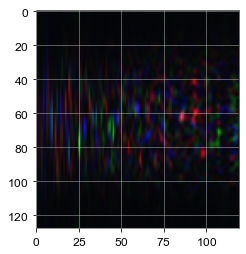

(128, 120, 3) ()


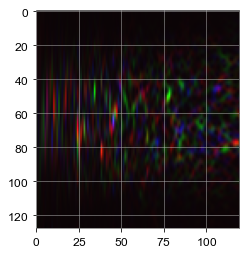

In [20]:
foo, bar = train_gen[0]
print(foo.shape, bar.shape)
plt.imshow(foo[0])
plt.show()

foo2, bar2 = val_gen[0]
print(foo2[0].shape, bar2[1].shape)
plt.imshow(foo2[0])

# Build CNN

Following tutorial here: https://www.tensorflow.org/tutorials/images/cnn

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Build Model

In [17]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(32, (6, 6), activation='relu', input_shape=(data_shape[0], data_shape[1], data_shape[2])))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# model.add(layers.Dense(2, activation='softmax'))
# model.add(layers.SoftMax())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 115, 32)      3488      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 11, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 8448)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

### Compile and Train Model

In [18]:
model.compile(optimizer='sgd',#'adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='binary_crossentropy',
#               loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

history = model.fit(train_gen, validation_data=val_gen,
                     epochs=2)#, callbacks=[model_checkpoint_callback])

Epoch 1/2
8/8 [==============================] - 26s 3s/step - loss: 0.6978 - accuracy: 0.3750 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/2
8/8 [==============================] - 24s 3s/step - loss: 0.6910 - accuracy: 0.5625 - val_loss: 0.6940 - val_accuracy: 0.5000


### Evaluate Model

KeyError: 'val_accuracy'

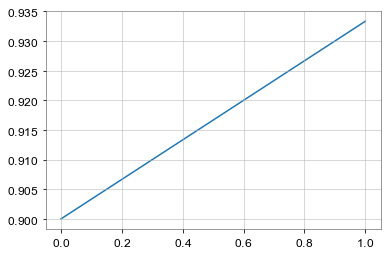

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_gen, verbose=1)

print(test_acc)

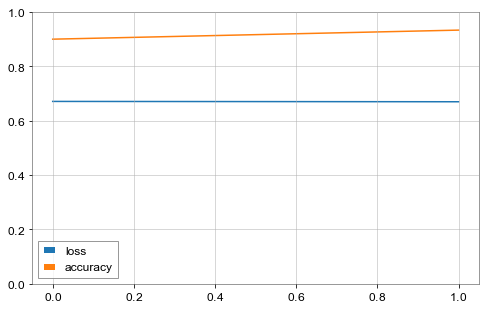

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig(\"keras_learning_curves_plot\")
plt.show()